In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
!ls

drive  sample_data


In [4]:
!cp drive/'My Drive'/Aligned.zip /content

In [5]:
!unzip /content/Aligned.zip

Streaming output truncated to the last 5000 lines.
  inflating: val/Positive/pos_332_0.jpg  
  inflating: val/Positive/pos_332_1.jpg  
  inflating: val/Positive/pos_332_2.jpg  
  inflating: val/Positive/pos_332_3.jpg  
  inflating: val/Positive/pos_332_4.jpg  
  inflating: val/Positive/pos_332_5.jpg  
  inflating: val/Positive/pos_333_0.jpg  
  inflating: val/Positive/pos_333_1.jpg  
  inflating: val/Positive/pos_334_0.jpg  
  inflating: val/Positive/pos_334_1.jpg  
  inflating: val/Positive/pos_334_2.jpg  
  inflating: val/Positive/pos_334_3.jpg  
  inflating: val/Positive/pos_334_4.jpg  
  inflating: val/Positive/pos_334_5.jpg  
  inflating: val/Positive/pos_334_6.jpg  
  inflating: val/Positive/pos_335_0.jpg  
  inflating: val/Positive/pos_335_1.jpg  
  inflating: val/Positive/pos_335_10.jpg  
  inflating: val/Positive/pos_335_11.jpg  
  inflating: val/Positive/pos_335_12.jpg  
  inflating: val/Positive/pos_335_13.jpg  
  inflating: val/Positive/pos_335_2.jpg  
  inflating: val/Posi

In [7]:
!cd Aligned/ && ls

Negative  Neutral  Positive


In [8]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import style
 
# Matplotlib configuration
%matplotlib inline  
style.use('fivethirtyeight')

# Keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten, Activation, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.utils.data_utils import get_file

# Tensorflow
import tensorflow as tf

# Image manipulation libraries
import cv2                  
from PIL import Image

# Other libraries
import random
from tqdm import tqdm
import os
import itertools

# Set seed for random number generators
np.random.seed(42)
random.seed(42)
#tf.random.set_seed(42)
tf.random.set_random_seed(42)

Using TensorFlow backend.


In [12]:
X = []
# labels
X_labels = []

# size of the image - 64x64
IMG_SIZE = 64

# assign variables for paths of each class
POSITIVE_DIR = 'Aligned/Positive/'
NEUTRAL_DIR = 'Aligned/Neutral/'
NEGATIVE_DIR = 'Aligned/Negative/'

In [13]:
def generate_data_from_images(emotion_type, directory):
  # tqdm used for progress bar
  # for each image in the specified directory
  for image in tqdm(os.listdir(directory)):
    filename = os.fsdecode(image)
    if filename.endswith(".jpg"): 
      # read the colored image
      image = cv2.imread(os.path.join(directory, image))
      # resize image to 64x64
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      
      # append the image as a numpy array to X
      X.append(np.array(image))
      # append the label to Z
      X_labels.append(emotion_type)

In [14]:
generate_data_from_images('Positive', POSITIVE_DIR)

100%|██████████| 12570/12570 [00:02<00:00, 4631.47it/s]


In [15]:
generate_data_from_images('Neutral', NEUTRAL_DIR)

100%|██████████| 10770/10770 [00:02<00:00, 4723.29it/s]


In [16]:
generate_data_from_images('Negative', NEGATIVE_DIR)

100%|██████████| 13738/13738 [00:02<00:00, 4835.04it/s]


In [17]:
len(X), len(X_labels)

(37078, 37078)

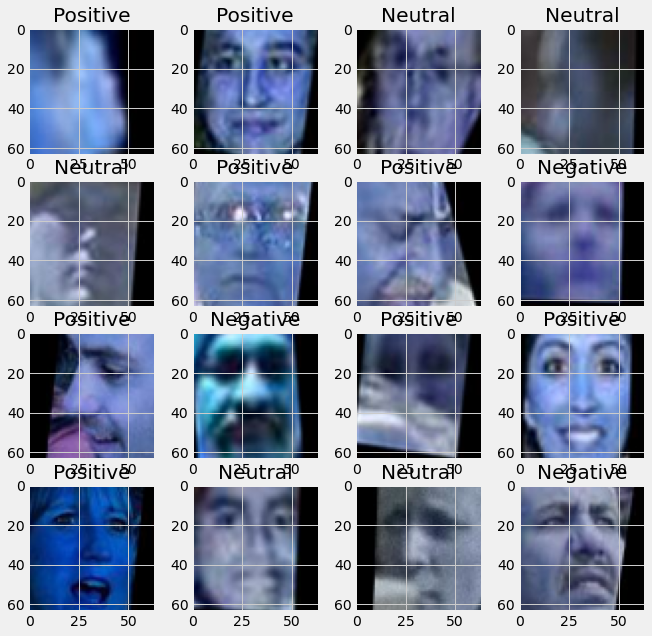

In [18]:
cols = 4
rows = 4
fig, axis = plt.subplots(rows, cols)
fig.set_size_inches(10, 10)
for i in range(rows):
  for j in range(cols):
    image_index = random.randint(0, len(X))
    axis[i, j].imshow(X[image_index])
    axis[i, j].set_title(X_labels[image_index])

In [19]:

# initialize the label encoder class
labelencoder = LabelEncoder()

# Convert the 3 classes "positive", "neutral" and "negative" into corresponding 
# numerical classes - 2, 1 and 0.
Y = labelencoder.fit_transform(X_labels)
# Check the classes applied by the Label Encoder
labelencoder_classes = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(labelencoder_classes)
# Apply one-hot encoding to convert the label encoded categorical data
# into multiple columns where each numerical class is replaced by 0 or 1
Y = to_categorical(Y,3)

# Convert X into a numpy array
X = np.array(X)
# Normalize all the pixel values for each image by diving by 255
X = X/255

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [20]:
num_features = 64
num_labels = 3
batch_size = 64
epochs = 100
width, height = 64, 64

#x = np.load('./fdataX.npy')
#y = np.load('./flabels.npy')

#x -= np.mean(x, axis=0)
#x /= np.std(x, axis=0)

#for xx in range(10):
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
#plt.show()

#splitting into training, validation and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', Y_test)

In [21]:

from tensorflow.keras import regularizers
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.models import Sequential

In [22]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-aa0gs_z7
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-aa0gs_z7
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=52f4d23f54b8573a34e43c1ccbdaf97238f4113caf41db9bbca06e541c7eeb1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1usjrnkl/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [23]:
# Most Recent One (Suggested)
#pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface

In [24]:
from keras import applications
import keras
from keras.applications import vgg16

In [25]:
!pip install keras_vggface

In [26]:
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras.engine import Model

# initialize the VGGFace model
# exclude the top layer and set input shape to the shape of our images
vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
# get the output of the last layer
last_layer = vgg_model.get_layer('pool5').output
# flatten the last layer
x = Flatten(name='flatten')(last_layer)
# add a fully connected layer with ReLu activation
x = Dense(512, activation='relu', name='fc6')(x)
# add another fully connected layer with ReLu activation
x = Dense(512, activation='relu', name='fc7')(x)
# add a final fully connected layer with 3 neurons corresponding to our 3 classes and 
# a softmax activation since this is a multiclass classification problem
out = Dense(3, activation='softmax', name='fc8')(x)
# set the input and output for the model
model = Model(vgg_model.input, out)

# compile the model
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58916864/58909280 [==============================] - 1s 0us/step


In [27]:
# set the paths for the weights file of VGG16
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# define the model
def VGG16():

    img_input = Input(shape=(64, 64, 3))
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = GlobalAveragePooling2D()(x)

    top = Dense(256, activation='relu', name='fc')(x)
    top = Dropout(0.5)(top)
    out = Dense(3, activation='softmax', name='predictions')(top)

    model = Model(img_input, out, name='vgg16')

    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            WEIGHTS_PATH_NO_TOP,
                            cache_subdir='models')
    model.load_weights(weights_path, by_name=True)
    
    return model


lr = 0.0001

optimizer = Adagrad(lr, decay=1e-4)
model = VGG16()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [28]:
batch_size=128
# batch_size = 64
# epochs=10

In [29]:
# define the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zoom_range = 0.1, 
        vertical_flip=False)

# fit on our training set
datagen.fit(X_train)

In [30]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [31]:
# get the position of the largest value for each label in y_train
# eg - argmax([0., 0., 1.]) = 2
y_ints = [y.argmax() for y in Y_train]
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)

In [32]:
callbacks = []
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(earlystop)

# history = model.fit(X_train,y_train, nb_epoch=400, \
#             batch_size=batch_size, \
#             validation_split=0.2, \
#             shuffle=True, verbose=1, \
#             callbacks=callbacks, class_weight=class_weights)

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 400, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks, class_weight=class_weights)


Epoch 1/400
234/234 [==============================] - 53s 229ms/step - loss: 1.0348 - accuracy: 0.4742 - val_loss: 0.9365 - val_accuracy: 0.5491
Epoch 2/400
234/234 [==============================] - 41s 175ms/step - loss: 0.9438 - accuracy: 0.5403 - val_loss: 0.9080 - val_accuracy: 0.5696
Epoch 3/400
234/234 [==============================] - 41s 176ms/step - loss: 0.9101 - accuracy: 0.5646 - val_loss: 0.8891 - val_accuracy: 0.5747
Epoch 4/400
234/234 [==============================] - 41s 177ms/step - loss: 0.8926 - accuracy: 0.5804 - val_loss: 0.8782 - val_accuracy: 0.5898
Epoch 5/400
234/234 [==============================] - 41s 177ms/step - loss: 0.8741 - accuracy: 0.5899 - val_loss: 0.8763 - val_accuracy: 0.5823
Epoch 6/400
234/234 [==============================] - 42s 178ms/step - loss: 0.8631 - accuracy: 0.5962 - val_loss: 0.8657 - val_accuracy: 0.5906
Epoch 7/400
234/234 [==============================] - 42s 178ms/step - loss: 0.8549 - accuracy: 0.6032 - val_loss: 0.8686 

In [33]:
# serialize model to JSON
model_json = model.to_json()
with open("vggface_adam.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("vggface_adam.h5")
print("Saved model to disk")

Saved model to disk


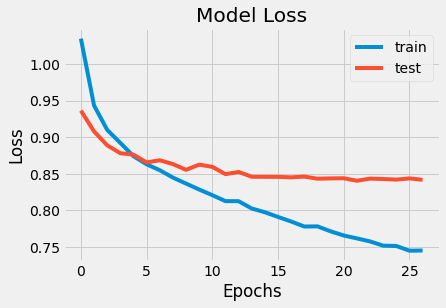

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

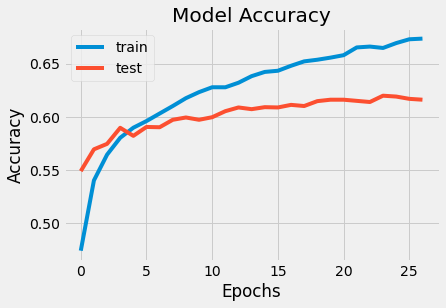

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [36]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(Y_test,axis = 1)

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[955 253 163]
 [395 523 154]
 [285 173 807]]


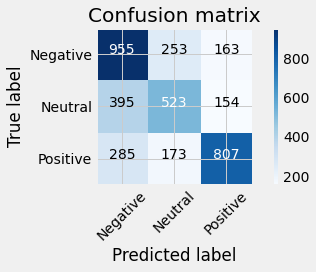

In [38]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=labelencoder.classes_)
plt.show()

In [39]:
accuracy_score(y_true, y_pred_classes)

0.616235167206041